In [64]:
from glob import glob as glob
import itertools

import torch as tr
import numpy as np

from PM_models import *
from PM_tasks import *
from helperfuns_dualPM import *

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### train acc

In [65]:
def load_tracc(stsize1,stsize2,ntrials):
  L = []
  fdir = 'model_data/dual_lstms_sweep1/'
  for seed in range(20):
    fpath = fdir+"lstm1_%i-lstm2_%i-ntrials_%i-seed_%i-tracc.npy" %(stsize1,stsize2,ntrials,seed)
    L.append(np.load(fpath))
  return np.array(L)
    

In [66]:
# load_tracc(15,30,1).shape

In [67]:
import pandas as pd

cols = ['acc','lstm1','lstm2','ntrials','seed']
df = pd.DataFrame(columns=cols)
data_dict = {}

fdir = 'model_data/dual_lstms_sweep1/'

stsize1L,stsize2L,ntrialsL,seedL = [15,20,25],[30,40,50],[1,2,3],np.arange(20)
for stsize1,stsize2,ntrials,seed in itertools.product(stsize1L,stsize2L,ntrialsL,seedL):
  fpath = fdir+"lstm1_%i-lstm2_%i-ntrials_%i-seed_%i-tracc.npy" %(stsize1,stsize2,ntrials,seed)
  try:
    tracc = np.load(fpath)
  except:
    continue
  acc = tracc[-10000:].mean()
  df_ = pd.DataFrame(np.array([[acc,stsize1,stsize2,ntrials,seed]]),columns=cols)
  df = df.append(df_)
  

In [68]:
{i[0]:i[1].shape for i in df.groupby(['lstm1','lstm2','ntrials'])}

{(15.0, 30.0, 1.0): (20, 5),
 (15.0, 30.0, 2.0): (20, 5),
 (15.0, 30.0, 3.0): (20, 5),
 (15.0, 40.0, 1.0): (20, 5),
 (15.0, 40.0, 2.0): (20, 5),
 (15.0, 40.0, 3.0): (20, 5),
 (15.0, 50.0, 1.0): (20, 5),
 (15.0, 50.0, 2.0): (20, 5),
 (15.0, 50.0, 3.0): (20, 5),
 (20.0, 30.0, 1.0): (20, 5),
 (20.0, 30.0, 2.0): (20, 5),
 (20.0, 30.0, 3.0): (20, 5),
 (20.0, 40.0, 1.0): (20, 5),
 (20.0, 40.0, 2.0): (20, 5),
 (20.0, 40.0, 3.0): (20, 5),
 (20.0, 50.0, 1.0): (20, 5),
 (20.0, 50.0, 2.0): (20, 5),
 (20.0, 50.0, 3.0): (20, 5),
 (25.0, 30.0, 1.0): (20, 5),
 (25.0, 30.0, 2.0): (20, 5),
 (25.0, 30.0, 3.0): (20, 5),
 (25.0, 40.0, 1.0): (20, 5),
 (25.0, 40.0, 2.0): (20, 5),
 (25.0, 40.0, 3.0): (20, 5),
 (25.0, 50.0, 1.0): (20, 5),
 (25.0, 50.0, 2.0): (20, 5),
 (25.0, 50.0, 3.0): (20, 5)}

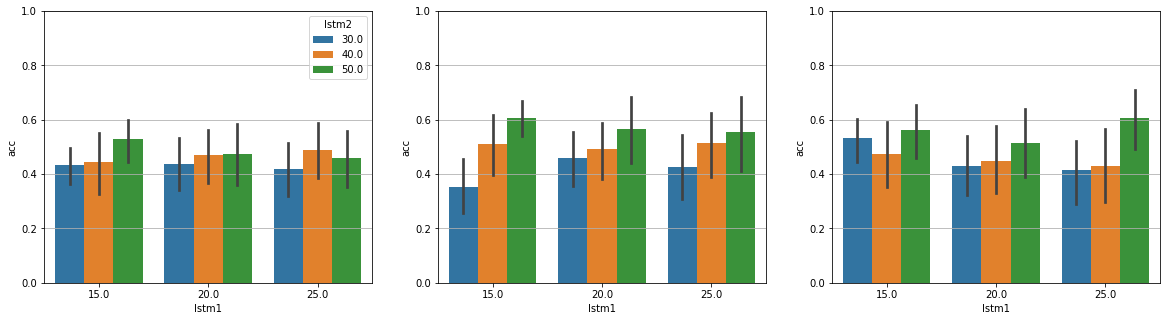

In [69]:
fig,axarr = plt.subplots(1,3,figsize=(20,5))
for idx in [1,2,3]:
  ax = axarr[idx-1]
  sub_df = df[df['ntrials']==idx]
  sns.barplot(data=sub_df,y='acc',x='lstm1',hue='lstm2',ax=ax,)
  if idx!=1: 
    ax.get_legend().remove()
  ax.set_ylim(0,1)
  ax.grid(axis='y')
  


# Train

In [70]:
def gen_data_fn(task,ntrials,trlen):
  i,x,y = task.gen_ep_data(num_trials=ntrials,
                           trial_len=trlen,
                           pm_probe_positions=np.arange(trlen))
  y = y.reshape(ntrials,trlen+nmaps)[:,nmaps:].reshape(-1,1)
  return i,x,y


In [ ]:
## similar to a complex span task
seed = 0
nmaps = 8
trlen = 30
ntrials = 1

L = []
for ntrials in [1,2,3]:
  trlen = int(30/ntrials)
  net = NetDualLSTMToy(stsize1=10,stsize2=30,seed=seed)
  task = TaskDualPM(num_back=1,nmaps=nmaps,seed=seed)
  lam_gen_data_fn = lambda: gen_data_fn(task,ntrials,trlen)
  tr_acc = train_net(net,task,neps=200000,gen_data_fn=lam_gen_data_fn,verb=True)
  L.append(tr_acc)

two LSTM layers
0.0 68.06299
0.2 62.37195
0.4 62.449703


In [ ]:
for tracc in L:
  plt.plot(mov_avg(tracc,200))